# 1. Motivation

### What is your dataset?  
Our primary dataset is the **NYC Motor Vehicle Collisions** dataset, which records every reported crash in New York City. We have supplemented it with two related tables:  
- **Vehicle-level data**: Details on each vehicle involved (type, make/model, contributing factors, damage).  
- **Person-level data**: Details on each person involved (injury severity, age, sex, person type, safety equipment).

### Why did you choose this/these particular dataset(s)?  
1. **Geospatial Richness** – Each record includes latitude/longitude and borough information, enabling map-based storytelling and hotspot analysis.  
2. **Course Relevance** – We’ve worked through a similar dataset (San Fran crime) in class, so we could build on familiar cleaning techniques.  
3. **Data Availability & Scale** – New York City publishes a vast, high-quality open dataset, covering over a decade of collisions and millions of records, which supports robust, real-world analytics.  
4. **Human Impact** – By combining collision, vehicle, and person data, I can explore not just where and when crashes happen, but who is affected and how—making the story more relatable.

### What was your goal for the end user’s experience?  
We want a **non-technical audience** (friends, family, or city residents) to intuitively understand:  
- **Where and when NYC streets are most dangerous**  
- **Which vehicles and behaviors pose the greatest risk**  
- **Who is most vulnerable** (e.g. age, pedestrian vs. driver)  

Through a clean narrative flow, interactive charts, and map visualizations, users should be able to explore Javi’s world—seeing both the big­picture patterns and drilling into details—without needing any background in data science.


# 2. Basic Stats

### Data Cleaning

Before analysis, I cleaned the `vehicle_crashes` dataset in a separate script to reduce load time and simplify this notebook. The steps included:

- Viewed the dataset of each attribute
- Converted `CRASH DATE` to datetime
- Dropped unused or redundant columns. `Location` because we alraedy have `Longitude` and `Latitude`. Supplementary street names not interesting and excessive contributing vehicles and type code.
- Cast high-cardinality columns to `category` to reduce memory usage
- Fixed inconsistent data types (e.g. ZIP codes, street names)
- Saved the cleaned result to: `vehicle_crashes_cleaned.parquet`

This significantly reduces the size of the dataset and enables us to work faster with the dataset as a parquet file because parquet files remembers the assigned datatypes.

➡️ See full cleaning script: [`explore_dataset.ipynb`](../data_cleaning/explore_dataset.ipynb)

### Key Points from exploratory data analysis

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import seaborn as sns

df_vehicle_crashes = pd.read_parquet("../optimized_datasets/vehicle_crashes_cleaned.parquet")

In [26]:
df_vehicle_crashes.head(10)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,...,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3
0,2021-09-11,2:39,NaN,<NA>,NaN,NaN,WHITESTONE EXPRESSWAY,2.0,0.0,0,...,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,4455765,Sedan,Sedan,NaN
1,2022-03-26,11:45,NaN,<NA>,NaN,NaN,QUEENSBORO BRIDGE UPPER,1.0,0.0,0,...,0,1,0,Pavement Slippery,NaN,NaN,4513547,Sedan,NaN,NaN
2,2023-11-01,1:29,BROOKLYN,11230,40.621790,-73.970024,OCEAN PARKWAY,1.0,0.0,0,...,0,1,0,Unspecified,Unspecified,Unspecified,4675373,Moped,Sedan,Sedan
3,2022-06-29,6:55,NaN,<NA>,NaN,NaN,THROGS NECK BRIDGE,0.0,0.0,0,...,0,0,0,Following Too Closely,Unspecified,NaN,4541903,Sedan,Pick-up Truck,NaN
4,2022-09-21,13:21,NaN,<NA>,NaN,NaN,BROOKLYN BRIDGE,0.0,0.0,0,...,0,0,0,Passing Too Closely,Unspecified,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN
5,2023-04-26,13:30,NaN,<NA>,NaN,NaN,WEST 54 STREET,0.0,0.0,0,...,0,0,0,Unspecified,Unspecified,NaN,4623759,Sedan,Box Truck,NaN
6,2023-11-01,7:12,NaN,<NA>,NaN,NaN,HUTCHINSON RIVER PARKWAY,0.0,0.0,0,...,0,0,0,Following Too Closely,Driver Inattention/Distraction,NaN,4675709,Sedan,Station Wagon/Sport Utility Vehicle,NaN
7,2023-11-01,8:01,NaN,<NA>,NaN,NaN,WEST 35 STREET,0.0,0.0,0,...,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,4675769,Sedan,NaN,NaN
8,2023-04-26,22:20,NaN,<NA>,NaN,NaN,<NA>,0.0,0.0,0,...,0,0,0,Unspecified,NaN,NaN,4623865,Sedan,Pick-up Truck,NaN
9,2021-09-11,9:35,BROOKLYN,11208,40.667202,-73.866500,<NA>,0.0,0.0,0,...,0,0,0,Unspecified,NaN,NaN,4456314,Sedan,NaN,NaN


In [27]:
print(df_vehicle_crashes["CRASH DATE"].min(), df_vehicle_crashes["CRASH DATE"].max())

2012-07-01 00:00:00 2025-04-08 00:00:00


In [28]:
# Center on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=13)

# Sample 1000 collisions to avoid browser lag
sample = df_vehicle_crashes.dropna(subset=["LATITUDE", "LONGITUDE"]).sample(1000)

for _, row in sample.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.75
    ).add_to(m)

m

C:\Users\gisle\AppData\Local\Temp\ipykernel_187516\3643990322.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_vehicle_crashes["CRASH_HOUR"] = pd.to_datetime(df_vehicle_crashes["CRASH TIME"], errors="coerce").dt.hour


<Axes: title={'center': 'Collisions by Hour'}, xlabel='CRASH_HOUR'>

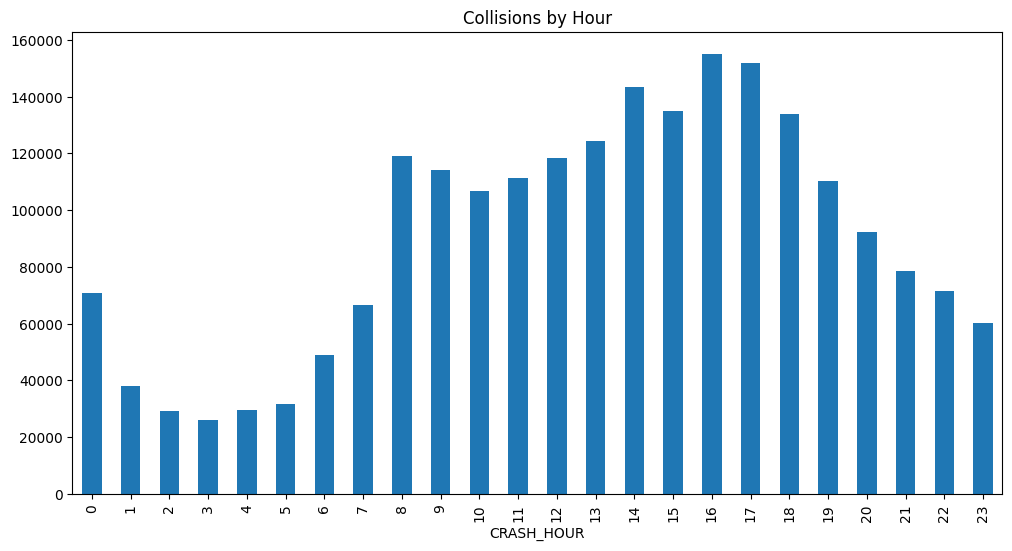

In [29]:
plt.figure(figsize=(12, 6))

df_vehicle_crashes["CRASH_HOUR"] = pd.to_datetime(df_vehicle_crashes["CRASH TIME"], errors="coerce").dt.hour
df_vehicle_crashes["CRASH_HOUR"].value_counts().sort_index().plot(kind="bar", title="Collisions by Hour")

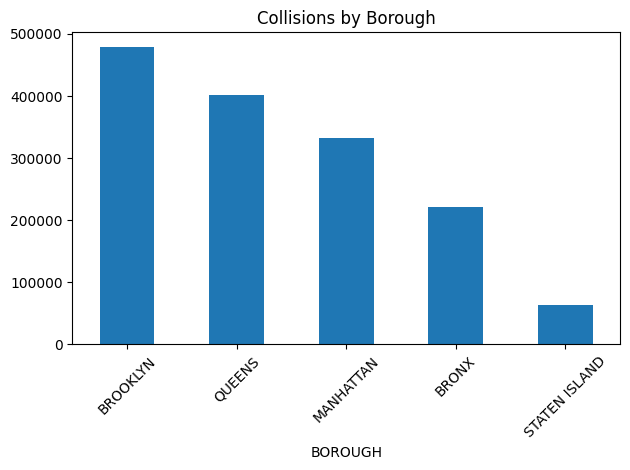

In [30]:
df_vehicle_crashes["BOROUGH"].value_counts().plot(kind="bar", title="Collisions by Borough")
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [31]:
df_vehicle_crashes["VEHICLE TYPE CODE 1"] = (
    df_vehicle_crashes["VEHICLE TYPE CODE 1"]
    .str.lower()
    .str.strip()
)

vehicle_type_mapping = {
    # Common car types
    "sedan": "Sedan",
    "4 dr sedan": "Sedan",
    "2 dr sedan": "Sedan",
    
    "station wagon/sport utility vehicle": "SUV",
    "sport utility / station wagon": "SUV",
    "passenger vehicle": "Passenger Vehicle",
    "pick-up truck": "Pickup Truck",
    "pick-up": "Pickup Truck",
    "p/u": "Pickup Truck",
    "van": "Van",
    "box truck": "Box Truck",
    
    # Variations
    "taxi": "Taxi",
    "taxicab": "Taxi",
    "t.a.x.i": "Taxi",
    "taxy": "Taxi",
    
    "bus": "Bus",
    "bus ": "Bus",   # with trailing space
    "b u s": "Bus",
    
    "motorcycle": "Motorcycle",
    "motorbike": "Motorcycle",
    "moped": "Moped",
    "motorscooter": "Motorcycle",
    
    "ambulance": "Ambulance",
    "ambul": "Ambulance",
    "amb": "Ambulance",
    
    "e-bike": "E-Bike",
    "e-scooter": "E-Scooter",
    
    # Catch-alls
    "unknown": "Unknown",
    "other": "Other"
}

df_vehicle_crashes["VEHICLE TYPE CLEANED"] = df_vehicle_crashes["VEHICLE TYPE CODE 1"].replace(vehicle_type_mapping)

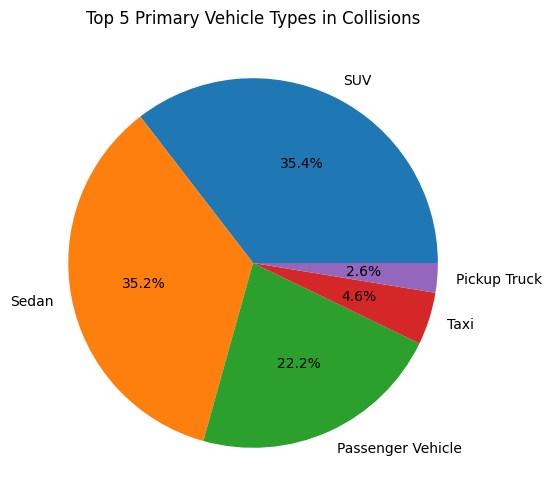

In [32]:
plt.figure(figsize=(20, 6))

top_vehicles = df_vehicle_crashes["VEHICLE TYPE CLEANED"].value_counts().head(5)
ax = top_vehicles.plot(
    kind="pie",
    autopct="%1.1f%%",
    title="Top 5 Primary Vehicle Types in Collisions",
    ylabel=""
)

plt.show()

In [33]:
# List df_vehicle_crashes["VEHICLE TYPE CODE 1"] top 50
top_50_vehicle_types = df_vehicle_crashes["VEHICLE TYPE CLEANED"].value_counts().head(50)

print(top_50_vehicle_types)

VEHICLE TYPE CLEANED
SUV                               665523
Sedan                             661243
Passenger Vehicle                 416206
Taxi                               86186
Pickup Truck                       48446
Bus                                37343
Van                                35240
Box Truck                          25801
Other                              22973
Unknown                            19954
bike                               16753
Motorcycle                         14687
large com veh(6 or more tires)     14397
small com veh(4 tires)             13216
tractor truck diesel               10967
livery vehicle                     10481
Ambulance                           8331
dump                                4234
convertible                         4024
E-Bike                              3783
Moped                               2780
pk                                  2748
E-Scooter                           2666
flat bed                            

# 3. Data Analysis

# Machine Learning?

Based on our analysis of attempting to find any linear relationships between two variables, this dataset contain very few continuous variables that we can apply linear regression analysis as we have gone through in the course. Below is our attempt at 

In [ ]:
# df_person = pd.read_parquet("../optimized_datasets/vehicle_crashes_person_cleaned.parquet")

In [ ]:
# df_person.head(10)

,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_TYPE,PERSON_INJURY,PERSON_AGE,EJECTION,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,4229554,2019-10-26,9:43,Occupant,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U
1,4230587,2019-10-25,15:15,Occupant,Unspecified,33.0,Not Ejected,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,NaN,NaN,F
2,4230550,2019-10-26,17:55,Occupant,Unspecified,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M
3,3565527,2016-11-21,13:05,Occupant,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4231168,2019-10-25,11:16,Occupant,Unspecified,7.0,Not Ejected,Right rear passenger or motorcycle sidecar pas...,Lap Belt,NaN,NaN,NaN,NaN,F
5,4230743,2019-10-24,19:15,Occupant,Injured,27.0,Not Ejected,Driver,Lap Belt & Harness,NaN,NaN,NaN,NaN,M
6,4230047,2019-10-26,16:45,Occupant,Unspecified,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F
7,4229547,2019-10-26,1:15,Pedestrian,Injured,24.0,NaN,NaN,NaN,Pedestrian/Bicyclist/Other Pedestrian at Inter...,Crossing With Signal,Unspecified,Unspecified,F
8,4229808,2019-10-26,13:04,Occupant,Unspecified,36.0,Not Ejected,Driver,Lap Belt & Harness,NaN,NaN,NaN,NaN,M
9,4230915,2019-10-24,8:20,Occupant,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U


In [ ]:
# print(df_person["CRASH_DATE"].min(), df_person["CRASH_DATE"].max())

2012-07-01 00:00:00 2025-04-08 00:00:00


In [ ]:
# Count number of people who are aged 0
# print(df_person[df_person["PERSON_AGE"] == 0].shape[0])

547661


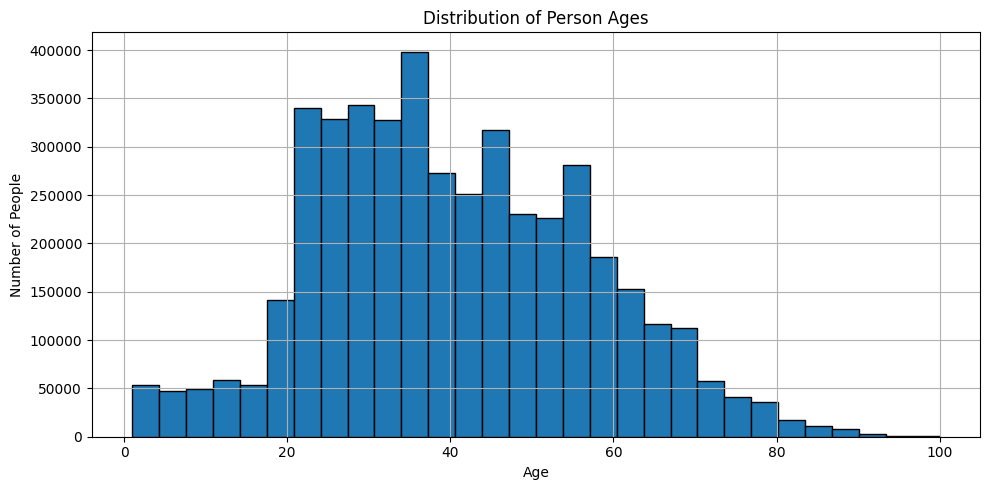

In [ ]:
"""


# Drop rows with missing age or injury
df_person = df_person.dropna(subset=["PERSON_AGE", "PERSON_INJURY"])

# Filter out unreasonable ages. We end up going with above age 0 because there were A HUGE DISPROPORTION of ages that were 0
# I believe that this is a data artefact and that when they calculated person_age = current_date - birth_date, they ended up with 0 for a lot of people as default
df_person = df_person[(df_person["PERSON_AGE"] > 0) & (df_person["PERSON_AGE"] <= 100)]

plt.figure(figsize=(10, 5))
df_person["PERSON_AGE"].plot(kind="hist", bins=30, edgecolor='black')
plt.title("Distribution of Person Ages")
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.grid(True)
plt.tight_layout()
plt.show()

"""

In [ ]:
"""

severity_map = {"Unspecified": 0, "Injured": 1, "Killed": 2}
df_person["injury_severity"] = df_person["PERSON_INJURY"].map(severity_map)

# Convert new column to a numeric dtype to do mean
df_person["injury_severity"] = df_person["injury_severity"].astype(float)

# Prepare x (age) and y (severity)
x = df_person["PERSON_AGE"].values
y = df_person["injury_severity"].values

# Compute regression slope (a) and intercept (b)
N = len(x)
x_mean = x.mean()
y_mean = y.mean()
a = (np.sum(x*y) - N*x_mean*y_mean) / (np.sum(x*x) - N*x_mean**2)
b = y_mean - a*x_mean

def calculate_r2(x, y, a, b):
    # Compute predicted y values
    y_pred = a * x + b

    # Compute SSR (Sum of Squared Residuals)
    ssr = np.sum((y - y_pred) ** 2)

    # Compute SST (Total Sum of Squares)
    sst = np.sum((y - np.mean(y)) ** 2)

    # Compute R-squared
    r2 = 1 - (ssr / sst)

    return r2

r2 = calculate_r2(x, y, a, b) 

"""

C:\Users\gisle\AppData\Local\Temp\ipykernel_187516\3451814366.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\gisle\anaconda3\envs\compTools\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


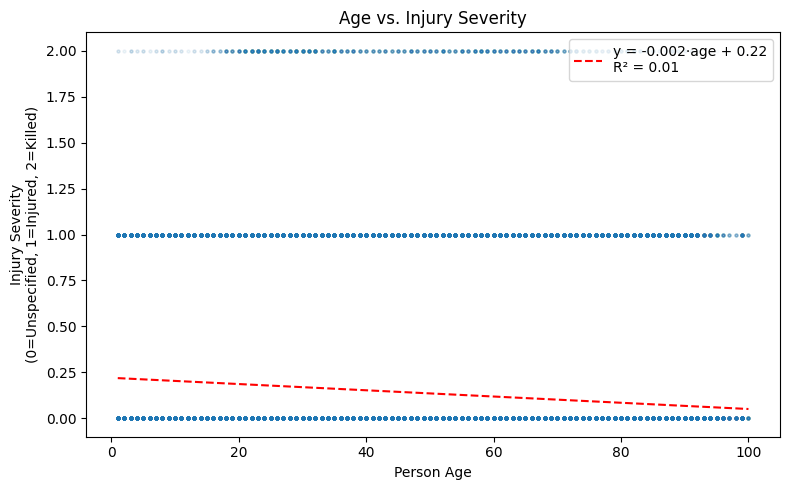

In [ ]:
"""

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.02, s=5)
x_range = np.linspace(x.min(), x.max(), 200)
plt.plot(x_range, a*x_range + b, color="red", linestyle="--",
         label=f"y = {a:.3f}·age + {b:.2f}\nR² = {r2:.2f}")
plt.xlabel("Person Age")
plt.ylabel("Injury Severity\n(0=Unspecified, 1=Injured, 2=Killed)")
plt.title("Age vs. Injury Severity")
plt.legend()
plt.tight_layout()
plt.show()

"""

# 4. Genre

# 5. Visualizations
What visualizations we ended up choosing for the website and how that contributes to the story?

# 6. Discussion

# 7. Contributions

# 8. References